In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Set of parameters initialized as per Protachevichz et al. 2021

def initialize_parameters():
    params = {
        "Cm": 200,        # Capacitance membrane (pF)
        "gL": 12,         # Leak conductance (nS)
        "EL": -70,        # Leak reversal potential (mV)
        "Delta_T": 2,     # Slope factor (mV)
        "d_exc": 1.5,     # Excitatory conductance time delay (ms)
        "d_inh": 0.8,     # Inhibitory conductance time delay (ms)
        "VT": -50,        # Spike threshold (mV)
        "I": 270,         # Injection current (pA)
        "aj_exc": np.random.uniform(1.9, 2.1) * 1,  # Subthreshold adaptation for excitatory neurons (nS)
        "bj_exc": 70,     # Spike-triggered adaptation for excitatory neurons (pA)
        "aj_inh": 0,      # Subthreshold adaptation for inhibitory neurons (nS)
        "bj_inh": 0,      # Spike-triggered adaptation for inhibitory neurons (pA)
        "tau_w": 300,     # Adaptation time constant (ms)
        "tau_s": 2.728,   # Synaptic time constant (ms)
        "Vr": -58,        # Reset potential (mV)
        "Vthres": -50,    # Threshold potential (mV)
        "Vexc_REV": 0,    # Excitatory reversal potential (mV)
        "Vinh_REV": -80,  # Inhibitory reversal potential (mV)
        "gee": 0.5,        # Synaptic conductance for excitatory to excitatory (nS)
        "gei": 2,       # Synaptic conductance for excitatory to inhibitory (nS)
        "gie": 1.5,        # Synaptic conductance for inhibitory to excitatory (nS)
        "gii": 2,        # Synaptic conductance for inhibitory to inhibitory (nS)
        'gAee': 3,
        'gAei': 6,
        'gAii': 4,
        'gAie': 4,
        "dt": 0.1,        # Time step (ms)
        "T": 1000,        # Total simulation time (ms)
        "N": 100,        # Number of neurons
        "Pexc": 0.8,      # Proportion of excitatory neurons
        "Pinh": 0.2,      # Proportion of inhibitory neurons
        "connection_prob": {
            "pee": 0.05,  # Excitatory to excitatory within area
            "pii": 0.2,   # Inhibitory to inhibitory within area
            "pei": 0.05,  # Excitatory to inhibitory within area
            "pie": 0.05,  # Inhibitory to excitatory within area
            "pAee": 0.01, # Excitatory to excitatory between areas
            "pAei": 0.05, # Excitatory to inhibitory between areas
            "pAii": 0.1,  # Inhibitory to inhibitory between areas
            "pAie": 0.05  # Inhibitory to excitatory between areas
        }
    }
    return params

# Example usage
params = initialize_parameters()
print(params)


{'Cm': 200, 'gL': 12, 'EL': -70, 'Delta_T': 2, 'd_exc': 1.5, 'd_inh': 0.8, 'VT': -50, 'I': 270, 'aj_exc': 2.0240920980592323, 'bj_exc': 70, 'aj_inh': 0, 'bj_inh': 0, 'tau_w': 300, 'tau_s': 2.728, 'Vr': -58, 'Vthres': -50, 'Vexc_REV': 0, 'Vinh_REV': -80, 'gee': 0.5, 'gei': 2, 'gie': 1.5, 'gii': 2, 'gAee': 3, 'gAei': 6, 'gAii': 4, 'gAie': 4, 'dt': 0.1, 'T': 1000, 'N': 100, 'Pexc': 0.8, 'Pinh': 0.2, 'connection_prob': {'pee': 0.05, 'pii': 0.2, 'pei': 0.05, 'pie': 0.05, 'pAee': 0.01, 'pAei': 0.05, 'pAii': 0.1, 'pAie': 0.05}}


In [3]:
params = initialize_parameters()

In [4]:
def initialize_neurons(params):
    N, P_exc = params['N'], params['Pexc']
    N_exc = int(N * P_exc)  # Number of excitatory neurons
    N_inh = N - N_exc       # Number of inhibitory neurons
    
    # Create an array with the first N_exc elements as 1 (excitatory) and the rest as -1 (inhibitory)
    neuron_types = np.array([1] * N_exc + [-1] * N_inh)
    
    return neuron_types

# Example usage
params = initialize_parameters()
neuron_types = initialize_neurons(params)
print(neuron_types)

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1]


In [5]:
def dVdt(V, w, I_chem):
    return (params['gL'] * (params['EL'] - V) + params['gL'] * params['Delta_T'] * np.exp((V - params['Vthres']) / params['Delta_T']) - w + I_chem + params['I']) / params['Cm']

def dwdt(V, w, neuron_types):
    a = np.where(neuron_types == 1, params['aj_exc'], 0)
    return (a * (V - params['EL']) - w) / params['tau_w']

def dg_syn_dt(g_syn):
    return -g_syn / params['tau_s']

def rk4_step(V, w, g_syn_exc, g_syn_inh, dt, I_chem, neuron_types):
    k1_V = dVdt(V, w, I_chem)
    k1_w = dwdt(V, w, neuron_types)
    k1_g_syn_exc = dg_syn_dt(g_syn_exc)
    k1_g_syn_inh = dg_syn_dt(g_syn_inh)
    
    k2_V = dVdt(V + 0.5 * dt * k1_V, w + 0.5 * dt * k1_w, I_chem)
    k2_w = dwdt(V + 0.5 * dt * k1_V, w + 0.5 * dt * k1_w, neuron_types)
    k2_g_syn_exc = dg_syn_dt(g_syn_exc + 0.5 * dt * k1_g_syn_exc)
    k2_g_syn_inh = dg_syn_dt(g_syn_inh + 0.5 * dt * k1_g_syn_inh)
    
    k3_V = dVdt(V + 0.5 * dt * k2_V, w + 0.5 * dt * k2_w, I_chem)
    k3_w = dwdt(V + 0.5 * dt * k2_V, w + 0.5 * dt * k2_w, neuron_types)
    k3_g_syn_exc = dg_syn_dt(g_syn_exc + 0.5 * dt * k2_g_syn_exc)
    k3_g_syn_inh = dg_syn_dt(g_syn_inh + 0.5 * dt * k2_g_syn_inh)
    
    k4_V = dVdt(V + dt * k3_V, w + dt * k3_w, I_chem)
    k4_w = dwdt(V + dt * k3_V, w + dt * k3_w, neuron_types)
    k4_g_syn_exc = dg_syn_dt(g_syn_exc + dt * k3_g_syn_exc)
    k4_g_syn_inh = dg_syn_dt(g_syn_inh + dt * k3_g_syn_inh)
    
    V_new = V + (dt / 6.0) * (k1_V + 2.0 * k2_V + 2.0 * k3_V + k4_V)
    w_new = w + (dt / 6.0) * (k1_w + 2.0 * k2_w + 2.0 * k3_w + k4_w)
    g_syn_exc_new = g_syn_exc + (dt / 6.0) * (k1_g_syn_exc + 2.0 * k2_g_syn_exc + 2.0 * k3_g_syn_exc + k4_g_syn_exc)
    g_syn_inh_new = g_syn_inh + (dt / 6.0) * (k1_g_syn_inh + 2.0 * k2_g_syn_inh + 2.0 * k3_g_syn_inh + k4_g_syn_inh)
    
    return V_new, w_new, g_syn_exc_new, g_syn_inh_new

In [16]:
def make_network(params):
    neurons = initialize_neurons(params)
    N = params['N']
    connectivity_within = {
        "pee": np.random.rand(N, N) < params["connection_prob"]["pee"],
        "pii": np.random.rand(N, N) < params["connection_prob"]["pii"],
        "pei": np.random.rand(N, N) < params["connection_prob"]["pei"],
        "pie": np.random.rand(N, N) < params["connection_prob"]["pie"]
    }

    connectivity_between = {
        "pAee": np.random.rand(N, N) < params["connection_prob"]["pAee"],
        "pAei": np.random.rand(N, N) < params["connection_prob"]["pAei"],
        "pAii": np.random.rand(N, N) < params["connection_prob"]["pAii"],
        "pAie": np.random.rand(N, N) < params["connection_prob"]["pAie"]
    }   
    V = np.zeros(N)
    w = np.zeros(N)
    g_exc = np.zeros(N)
    g_inh = np.zeros(N)
    
    for i in range(N):
        V[i] = np.random.uniform(params['EL'],params['VT'])
        
    for j in range(N):
        w[j] = np.random.uniform(0,3) if neurons[j]==1 else 0
                
    return connectivity_between,connectivity_within,V,w,g_exc,g_inh

 
def simulate(params):
    connectivity_between,connectivity_within,V,w,g_exc,g_inh = make_network(params)
    dt = 0.02
    T = 4000
    N = int(params['N'])
    neurons = initialize_neurons(params)
    simulation_time = int(T/dt)
    V_trace = np.zeros((simulation_time, N))
    spikes = np.zeros((simulation_time, N))
    for t in range(simulation_time):
        spike_time = 0
        for j in range(N):
            #Spike when crosses threshold
            if V[j] >= params['Vthres']:
                V[j] = params['Vr']
                w[j] += params['bj_exc'] if neurons[j]==1 else params['bj_inh']

                if neurons[j] == 1:
                    g_exc += params['gee']*connectivity_within['pee'][j,:]*connectivity_within['pei'][j,:]
                if neurons[j] == -1:
                    g_inh += params['gii']*connectivity_within['pii'][j,:]*connectivity_within['pie'][j,:]
                
                spike_time += t*0.02
                spikes[t,j] += 1
            Isyn_exc = g_exc[j]*(params['Vexc_REV'] - V[j])*(spike_time - params['d_exc'])
            Isyn_inh = g_inh[j]*(params['Vinh_REV'] - V[j])*(spike_time - params['d_inh'])
            
            I_chem = Isyn_exc + Isyn_inh
            
        V, w, g_exc, g_inh = rk4_step(V, w, g_exc, g_inh, dt, I_chem,neurons)
        V_trace[t,:] += V
    return V_trace,w,spikes    
            


In [17]:
V_trace,w,spikes = simulate(params)

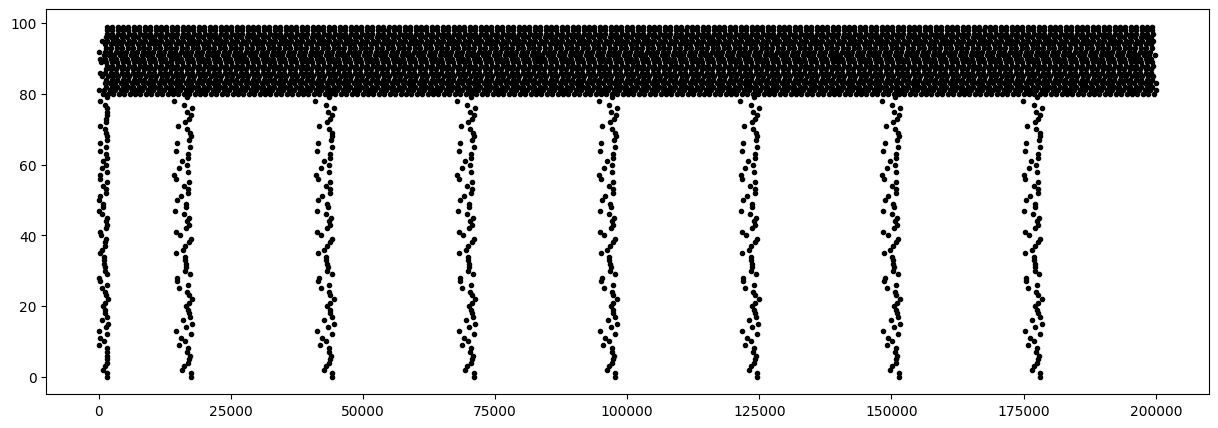

In [19]:
plt.figure(figsize=(15,5))

plt.scatter(np.where(spikes==1)[0],np.where(spikes==1)[1],color='k',marker='.')

In [21]:
def compute_phase_array(spikes, t):
    """
    Compute the phase of each neuron at time t using the spike array.
    
    Parameters:
    spikes : 2D array (timesteps x number of neurons)
        Binary spike array where 1 indicates a spike and 0 indicates no spike.
    t : int
        Current time index.
    
    Returns:
    array
        Phases of all neurons at time t.
    """
    phases = np.zeros(spikes.shape[1])
    for neuron in range(spikes.shape[1]):
        spike_times = np.where(spikes[:, neuron] == 1)[0]
        if len(spike_times) < 2:
            continue
        for m in range(len(spike_times) - 1):
            if spike_times[m] <= t < spike_times[m + 1]:
                phases[neuron] = 2 * np.pi * m + 2 * np.pi * (t - spike_times[m]) / (spike_times[m + 1] - spike_times[m])
                break
    return phases

def compute_order_parameter(spikes, t):
    """
    Compute the order parameter R(t) using the spike array.
    
    Parameters:
    spikes : 2D array (timesteps x number of neurons)
        Binary spike array where 1 indicates a spike and 0 indicates no spike.
    t : int
        Current time index.
    
    Returns:
    float
        Order parameter R(t).
    """
    phases = compute_phase_array(spikes, t)
    complex_phases = np.exp(1j * phases)
    return np.abs(np.sum(complex_phases) / spikes.shape[1])

def compute_time_avg_order_parameter(spikes, t_ini, t_fin):
    """
    Compute the time-averaged order parameter.
    
    Parameters:
    spikes : 2D array (timesteps x number of neurons)
        Binary spike array where 1 indicates a spike and 0 indicates no spike.
    t_ini : int
        Initial time index.
    t_fin : int
        Final time index.
    
    Returns:
    float
        Time-averaged order parameter.
    """
    R_values = [compute_order_parameter(spikes, t) for t in range(t_ini, t_fin)]
    return np.mean(R_values)

def compute_area_order_parameter(spikes, t, A, N):
    """
    Compute the order parameter for each area.
    
    Parameters:
    spikes : 2D array (timesteps x number of neurons)
        Binary spike array where 1 indicates a spike and 0 indicates no spike.
    t : int
        Current time index.
    A : int
        Area number.
    N : int
        Number of neurons in each area.
    
    Returns:
    float
        Order parameter for the area A.
    """
    start_idx = (A - 1) * N
    end_idx = A * N
    phases = compute_phase_array(spikes[:, start_idx:end_idx], t)
    complex_phases = np.exp(1j * phases)
    return np.abs(np.sum(complex_phases) / N)

def compute_real_imag_components(spikes, t, A, N):
    """
    Compute the real and imaginary components of the order parameter for an area.
    
    Parameters:
    spikes : 2D array (timesteps x number of neurons)
        Binary spike array where 1 indicates a spike and 0 indicates no spike.
    t : int
        Current time index.
    A : int
        Area number.
    N : int
        Number of neurons in each area.
    
    Returns:
    tuple of float
        Real and imaginary components of the order parameter.
    """
    start_idx = (A - 1) * N
    end_idx = A * N
    phases = compute_phase_array(spikes[:, start_idx:end_idx], t)
    cos_values = np.cos(phases)
    sin_values = np.sin(phases)
    RxA = np.sum(cos_values) / N
    RyA = np.sum(sin_values) / N
    return RxA, RyA

def compute_phase_angle(RxA, RyA):
    """
    Compute the phase angle for an area.
    
    Parameters:
    RxA : float
        Real component of the order parameter.
    RyA : float
        Imaginary component of the order parameter.
    
    Returns:
    float
        Phase angle.
    """
    return np.arctan2(RyA, RxA)

In [26]:
Rs = []
for i in range(100):
    R = compute_order_parameter(spikes,i)
    Rs.append(R)

In [49]:
spikes.T.shape

(100, 500000)

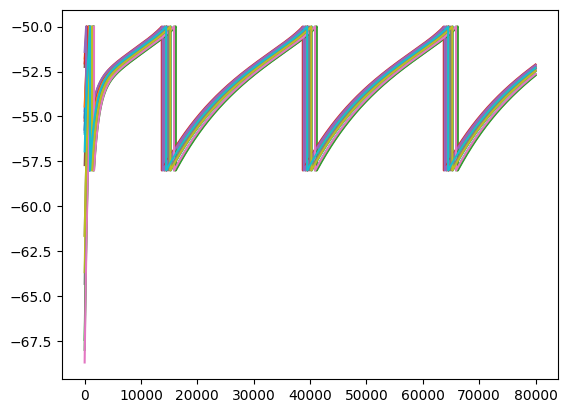

In [39]:
for i in range(len(V_trace.T)):
    if i < 20 :
        plt.plot(V_trace.T[i][0:80000])

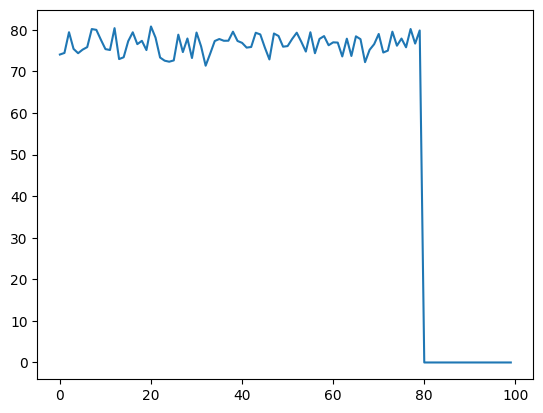

In [40]:
plt.plot(w)

In [7]:
import numpy as np


def make_network(params):
    neurons_A = initialize_neurons(params)
    neurons_B = initialize_neurons(params)
    N = params['N']
    
    connectivity_within_A = {
        "pee": np.random.rand(N, N) < params["connection_prob"]["pee"],
        "pii": np.random.rand(N, N) < params["connection_prob"]["pii"],
        "pei": np.random.rand(N, N) < params["connection_prob"]["pei"],
        "pie": np.random.rand(N, N) < params["connection_prob"]["pie"]
    }

    

    connectivity_between = {
        "pAee": np.random.rand(N, N) < params["connection_prob"]["pAee"],
        "pAei": np.random.rand(N, N) < params["connection_prob"]["pAei"],
        "pAii": np.random.rand(N, N) < params["connection_prob"]["pAii"],
        "pAie": np.random.rand(N, N) < params["connection_prob"]["pAie"]
    }   
    
    V_A = np.random.uniform(params['EL'], params['VT'], N)
    V_B = np.random.uniform(params['EL'], params['VT'], N)
    w_A = np.random.uniform(0, 3, N) * (neurons_A == 1)
    w_B = np.random.uniform(0, 3, N) * (neurons_B == 1)
    g_exc_A = np.zeros(N)
    g_inh_A = np.zeros(N)
    g_exc_B = np.zeros(N)
    g_inh_B = np.zeros(N)
    
    return (connectivity_within_A, connectivity_between, 
            V_A, V_B, w_A, w_B, g_exc_A, g_inh_A, g_exc_B, g_inh_B, neurons_A, neurons_B)


def simulate(params):
    (connectivity_within_A , connectivity_between, 
     V_A, V_B, w_A, w_B, g_exc_A, g_inh_A, g_exc_B, g_inh_B, neurons_A, neurons_B) = make_network(params)
    
    dt = 0.02
    T = 10000
    N = int(params['N'])
    simulation_time = int(T / dt)
    
    V_trace_A = np.zeros((simulation_time, N))
    V_trace_B = np.zeros((simulation_time, N))
    spikes_A = np.zeros((simulation_time, N))
    spikes_B = np.zeros((simulation_time, N))
    
    for t in range(simulation_time):
        spike_time_A = 0
        spike_time_B = 0
        
        for j in range(N):
            if V_A[j] >= params['Vthres']:
                V_A[j] = params['Vr']
                w_A[j] += params['bj_exc'] if neurons_A[j] == 1 else params['bj_inh']
                
                if neurons_A[j] == 1:
                    g_exc_A += params['gee'] * connectivity_within_A['pee'][j, :]*connectivity_within_A['pei'][j, :]
                if neurons_A[j] == -1:
                    g_inh_A += params['gii'] * connectivity_within_A['pii'][j, :]*connectivity_within_A['pie'][j, :]
                
                spike_time_A += t * dt
                spikes_A[t, j] += 1
                
            if V_B[j] >= params['Vthres']:
                V_B[j] = params['Vr']
                w_B[j] += params['bj_exc'] if neurons_B[j] == 1 else params['bj_inh']
                
                if neurons_B[j] == 1:
                    g_exc_B += params['gee'] * connectivity_within_A['pee'][j, :]*connectivity_within_A['pei'][j, :]
                if neurons_B[j] == -1:
                    g_inh_B += params['gii'] * connectivity_within_A['pii'][j, :]*connectivity_within_A['pie'][j, :]
                
                spike_time_B += t * dt
                spikes_B[t, j] += 1
                
            Isyn_exc_A = g_exc_A[j] * (params['Vexc_REV'] - V_A[j]) * (spike_time_A - params['d_exc'])
            Isyn_inh_A = g_inh_A[j] * (params['Vinh_REV'] - V_A[j]) * (spike_time_A - params['d_inh'])
            
            Isyn_exc_B = g_exc_B[j] * (params['Vexc_REV'] - V_B[j]) * (spike_time_B - params['d_exc'])
            Isyn_inh_B = g_inh_B[j] * (params['Vinh_REV'] - V_B[j]) * (spike_time_B - params['d_inh'])
            
            I_chem_A = Isyn_exc_A + Isyn_inh_A
            I_chem_B = Isyn_exc_B + Isyn_inh_B
            
            # Handle the interactions between Area A and Area B
            
            I_between_AB = (
            np.sum(params['gAee'] * connectivity_between['pAee'][:, j] * (V_A - V_B)) +
            np.sum(params['gAei'] * connectivity_between['pAei'][:, j] * (V_A - V_B)) +
            np.sum(params['gAii'] * connectivity_between['pAii'][:, j] * (V_A - V_B)) +
            np.sum(params['gAie'] * connectivity_between['pAie'][:, j] * (V_A - V_B))
            )
        
        I_chem_B += I_between_AB
        
        V_A, w_A, g_exc_A, g_inh_A = rk4_step(V_A, w_A, g_exc_A, g_inh_A, dt, I_chem_A, neurons_A)
        V_B, w_B, g_exc_B, g_inh_B = rk4_step(V_B, w_B, g_exc_B, g_inh_B, dt, I_chem_B, neurons_B)
        
        V_trace_A[t, :] = V_A
        V_trace_B[t, :] = V_B
    
    return V_trace_A, V_trace_B, spikes_A, spikes_B


In [8]:
V_trace_A, V_trace_B, spikes_A, spikes_B = simulate(params)

In [9]:
V_trace_A.shape

(500000, 100)

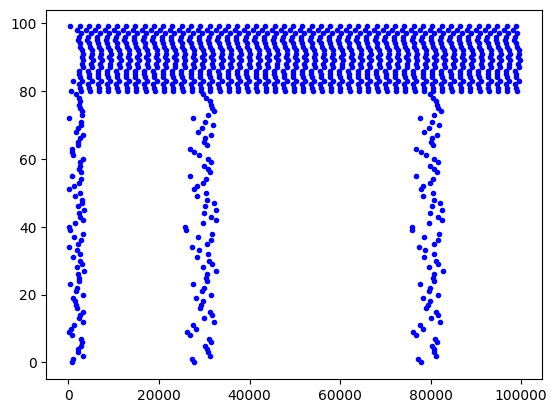

In [72]:
for i in range(len(spikes_A.T)):
    if i % 1000 == 0:
        plt.scatter(np.where(spikes_A==1)[0],np.where(spikes_A==1)[1],color='b',marker='.')

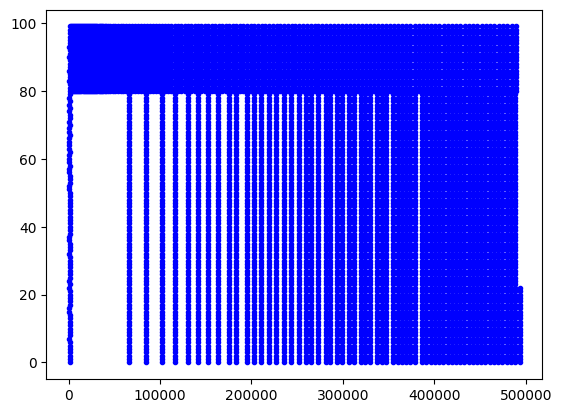

In [15]:

plt.scatter(np.where(spikes_A==1)[0][0:8000],np.where(spikes_A==1)[1][0:8000],color='b',marker='.')

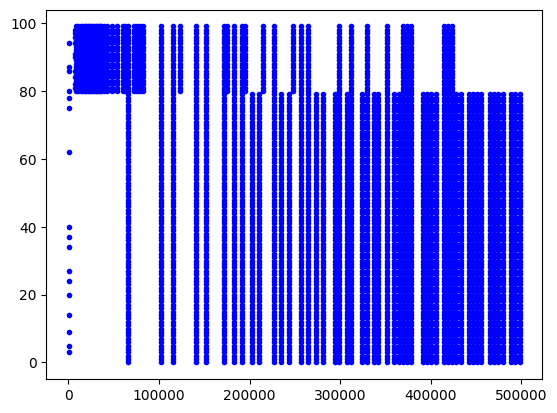

In [14]:
plt.scatter(np.where(spikes_B==1)[0][0:8000],np.where(spikes_B==1)[1][0:8000],color='b',marker='.')

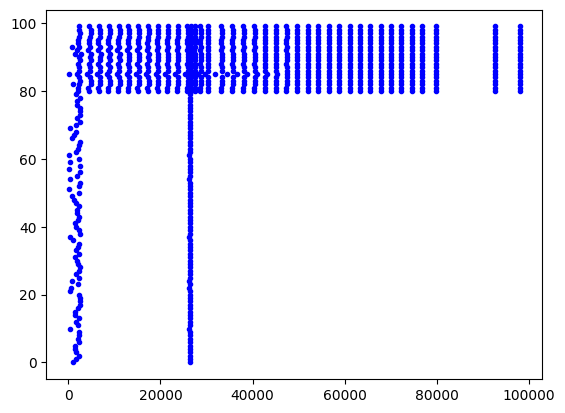

In [73]:
for i in range(len(spikes_B.T)):
    if i % 1000 == 0:
        plt.scatter(np.where(spikes_B==1)[0],np.where(spikes_B==1)[1],color='b',marker='.')

In [13]:
neurons = initialize_neurons(params)

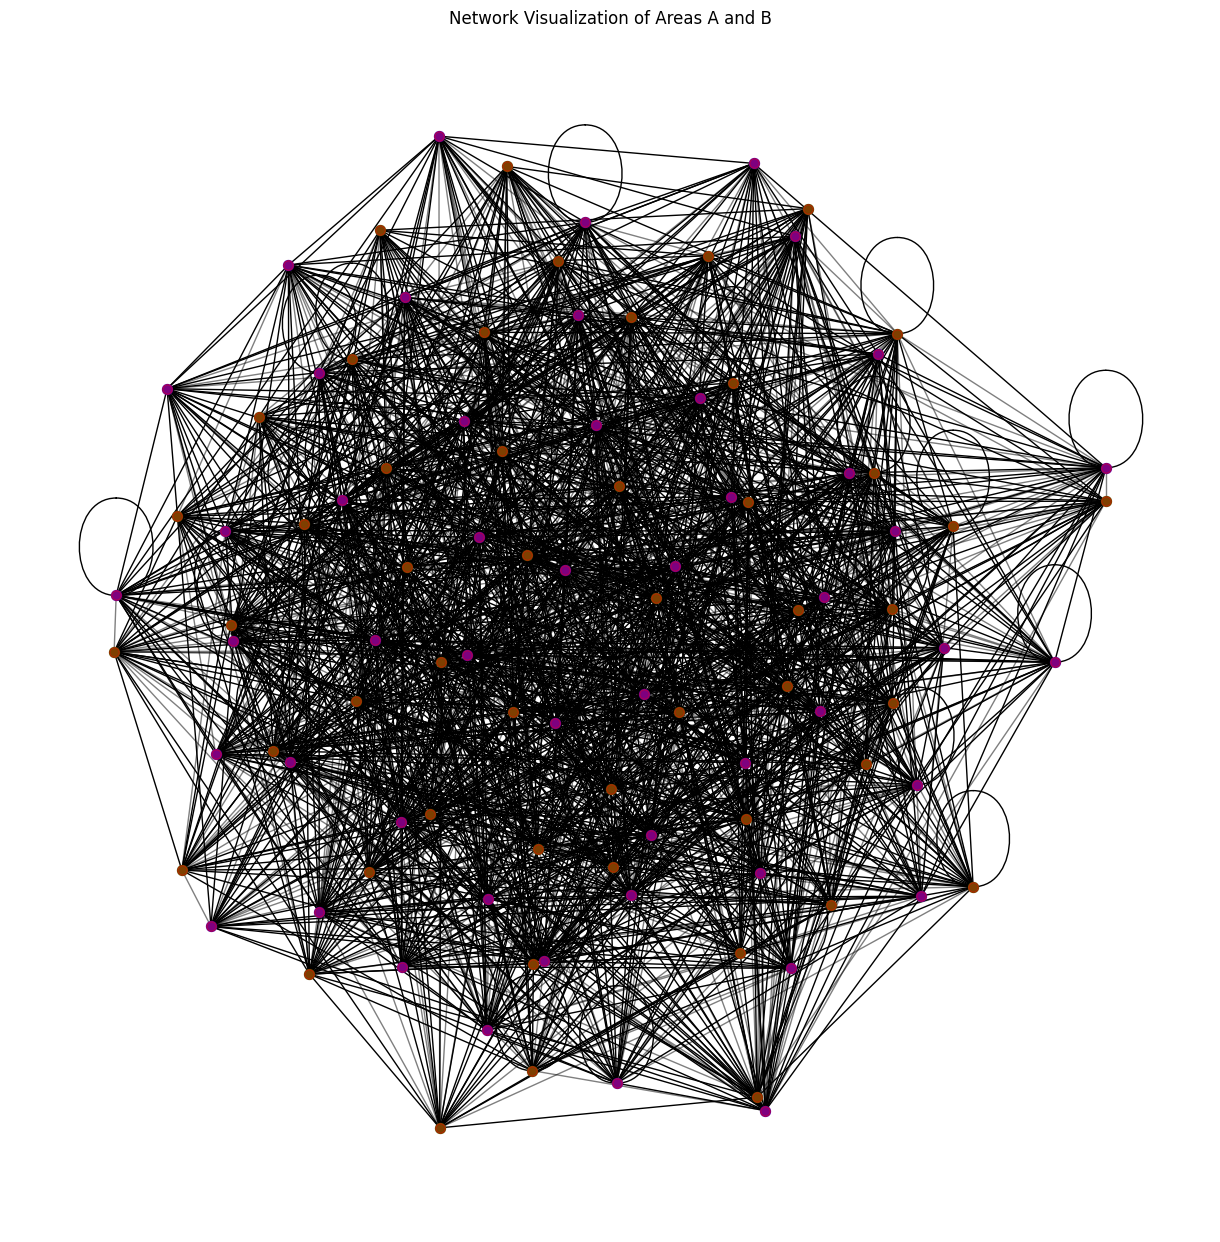

In [17]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Function to initialize parameters
def initialize_parameters():
    params = {
        "N": 1000,
        "Pexc": 0.8,
        "Pinh": 0.2,
        "connection_prob": {
            "pee": 0.05,
            "pii": 0.2,
            "pei": 0.05,
            "pie": 0.05,
            "pAee": 0.01,
            "pAei": 0.05,
            "pAii": 0.1,
            "pAie": 0.05
        }
    }
    return params

# Function to initialize the network
def initialize_network(params):
    N = 100
    neuron_types = np.random.choice([0, 1], size=N, p=[params["Pinh"], params["Pexc"]])
    
    connectivity_within = {
        "pee": np.random.rand(N, N) < params["connection_prob"]["pee"],
        "pii": np.random.rand(N, N) < params["connection_prob"]["pii"],
        "pei": np.random.rand(N, N) < params["connection_prob"]["pei"],
        "pie": np.random.rand(N, N) < params["connection_prob"]["pie"]
    }

    connectivity_between = {
        "pAee": np.random.rand(N, N) < params["connection_prob"]["pAee"],
        "pAei": np.random.rand(N, N) < params["connection_prob"]["pAei"],
        "pAii": np.random.rand(N, N) < params["connection_prob"]["pAii"],
        "pAie": np.random.rand(N, N) < params["connection_prob"]["pAie"]
    }
    
    return neuron_types, connectivity_within, connectivity_between

# Function to visualize the network
def visualize_network(neuron_types, connectivity_within, connectivity_between):
    N = len(neuron_types)
    area_size = N // 2
    
    G_A = nx.Graph()
    G_B = nx.Graph()
    
    # Add nodes to each area graph
    G_A.add_nodes_from(range(area_size))
    G_B.add_nodes_from(range(area_size, N))
    
    # Add edges within area A
    for i in range(area_size):
        for j in range(area_size):
            if connectivity_within["pee"][i, j]:
                G_A.add_edge(i, j)
            if connectivity_within["pie"][i, j]:
                G_A.add_edge(i, j)
            if connectivity_within["pei"][i, j]:
                G_A.add_edge(i, j)
            if connectivity_within["pii"][i, j]:
                G_A.add_edge(i, j)
    
    # Add edges within area B
    for i in range(area_size, N):
        for j in range(area_size, N):
            if connectivity_within["pee"][i, j]:
                G_B.add_edge(i, j)
            if connectivity_within["pie"][i, j]:
                G_B.add_edge(i, j)
            if connectivity_within["pei"][i, j]:
                G_B.add_edge(i, j)
            if connectivity_within["pii"][i, j]:
                G_B.add_edge(i, j)
    
    # Add edges between areas A and B
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(area_size):
        for j in range(area_size, N):
            if connectivity_between["pAee"][i, j]:
                G.add_edge(i, j)
            if connectivity_between["pAie"][i, j]:
                G.add_edge(i, j)
            if connectivity_between["pAei"][i, j]:
                G.add_edge(i, j)
            if connectivity_between["pAii"][i, j]:
                G.add_edge(i, j)
    
    # Draw the networks
    pos_A = nx.spring_layout(G_A)
    pos_B = nx.spring_layout(G_B)
    pos = {i: pos_A[i] if i in pos_A else pos_B[i] for i in range(N)}
    
    plt.figure(figsize=(12, 12))
    nx.draw(G_A, pos_A, node_color='blue', node_size=50, with_labels=False)
    nx.draw(G_B, pos_B, node_color='green', node_size=50, with_labels=False)
    nx.draw(G, pos, node_color='red', node_size=50, with_labels=False, alpha=0.5)
    
    plt.title("Network Visualization of Areas A and B")
    plt.show()

# Main function to run the simulation and visualization
def main():
    params = initialize_parameters()
    neuron_types, connectivity_within, connectivity_between = initialize_network(params)
    visualize_network(neuron_types, connectivity_within, connectivity_between)

main()


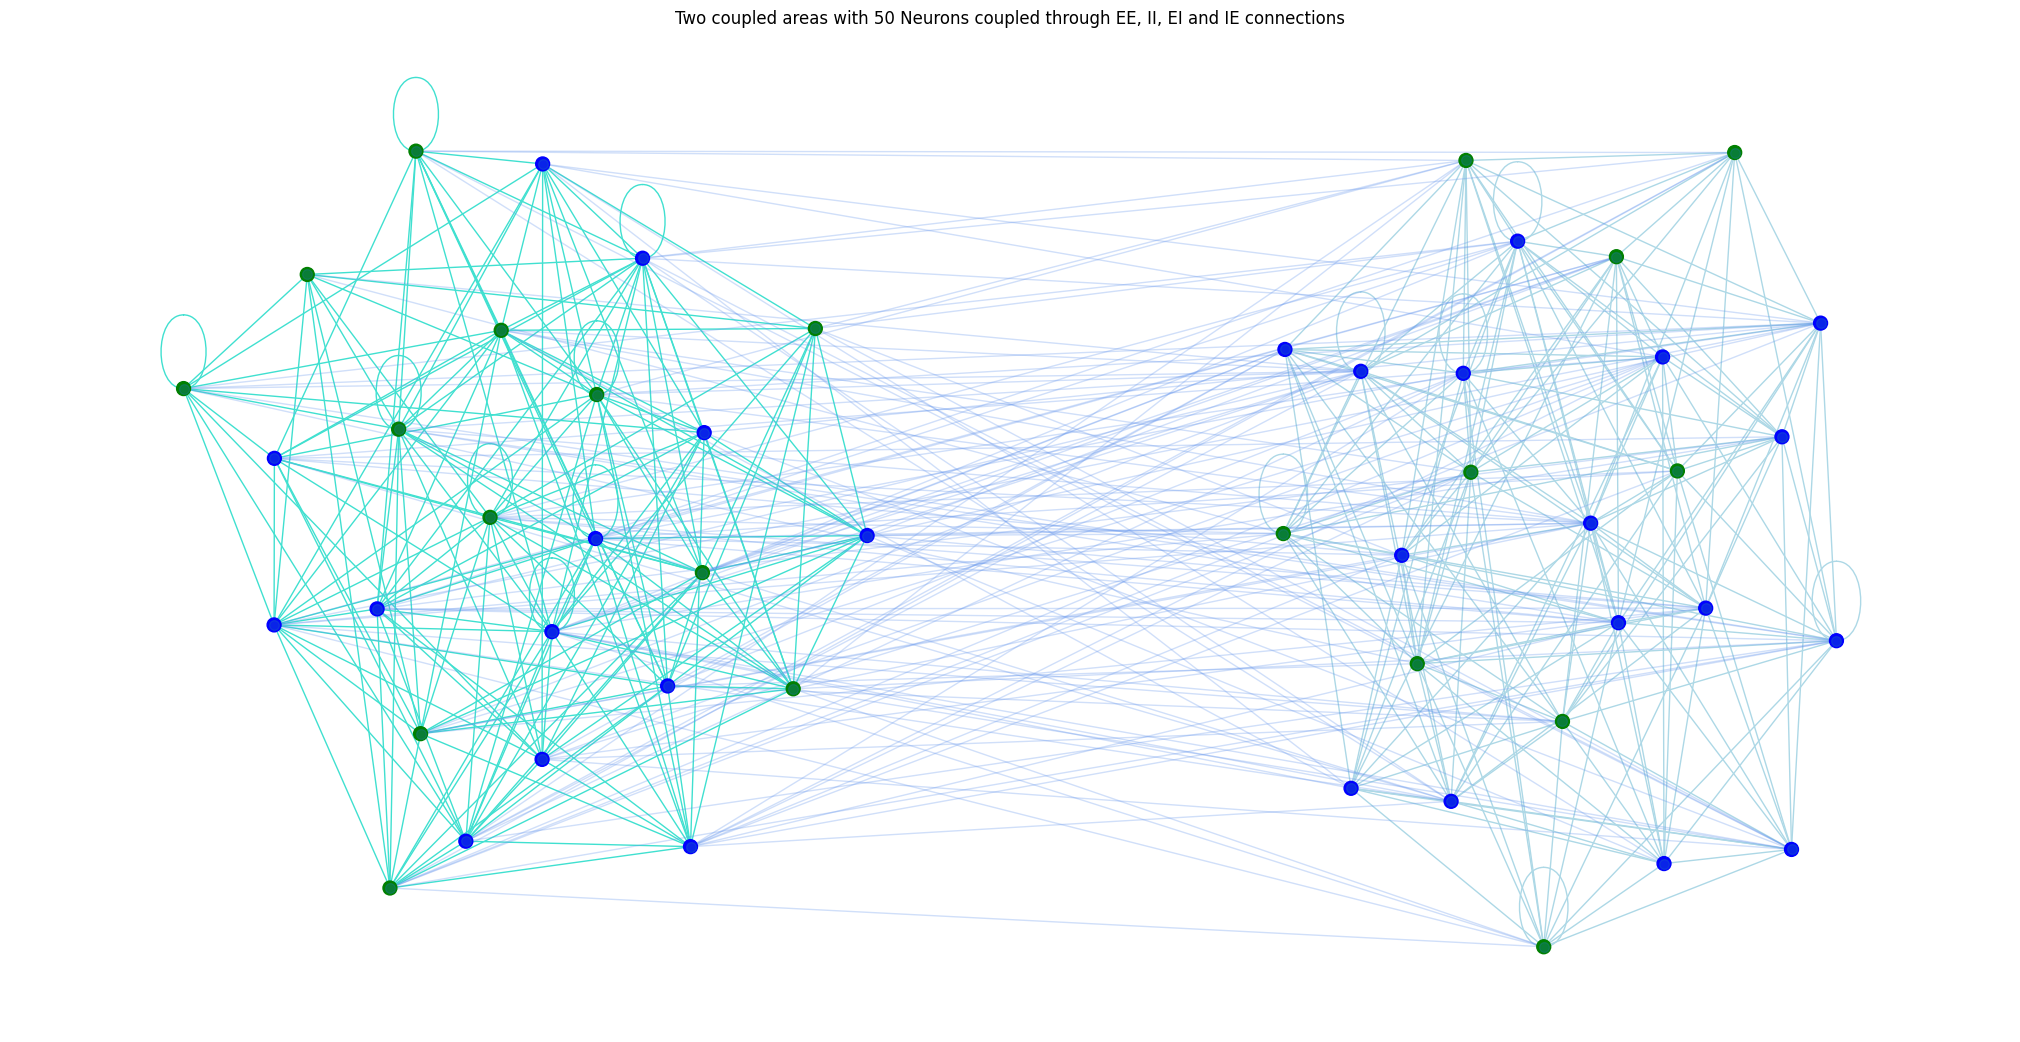

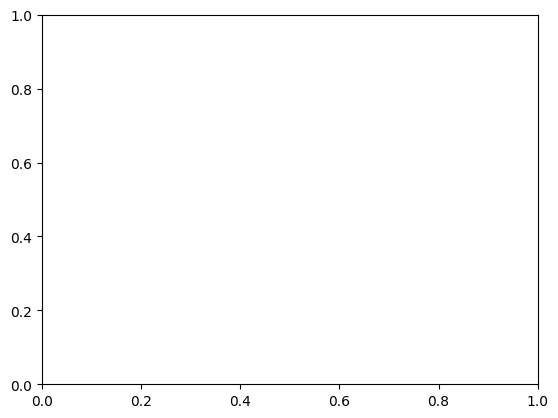

In [25]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
# Function to initialize parameters
def initialize_parameters():
    params = {
        "N": 1000,
        "Pexc": 0.5,
        "Pinh": 0.5,
        "connection_prob": {
            "pee": 0.05,
            "pii": 0.2,
            "pei": 0.05,
            "pie": 0.05,
            "pAee": 0.01,
            "pAei": 0.05,
            "pAii": 0.1,
            "pAie": 0.05
        }
    }
    return params

# Function to initialize the network
def initialize_network(params):
    N = 50
    
    neuron_types = np.random.choice([0, 1], size=N, p=[params["Pinh"], params["Pexc"]])
    
    connectivity_within = {
        "pee": np.random.rand(N, N) < params["connection_prob"]["pee"],
        "pii": np.random.rand(N, N) < params["connection_prob"]["pii"],
        "pei": np.random.rand(N, N) < params["connection_prob"]["pei"],
        "pie": np.random.rand(N, N) < params["connection_prob"]["pie"]
    }

    connectivity_between = {
        "pAee": np.random.rand(N, N) < params["connection_prob"]["pAee"],
        "pAei": np.random.rand(N, N) < params["connection_prob"]["pAei"],
        "pAii": np.random.rand(N, N) < params["connection_prob"]["pAii"],
        "pAie": np.random.rand(N, N) < params["connection_prob"]["pAie"]
    }
    
    return neuron_types, connectivity_within, connectivity_between

# Function to visualize the network
def visualize_network(neuron_types, connectivity_within, connectivity_between):
    N = len(neuron_types)
    area_size = N // 2
    
    G_A = nx.Graph()
    G_B = nx.Graph()
    
    # Add nodes to each area graph
    G_A.add_nodes_from(range(area_size))
    G_B.add_nodes_from(range(area_size, N))
    
    # Add edges within area A
    for i in range(area_size):
        for j in range(area_size):
            if connectivity_within["pee"][i, j] or connectivity_within["pei"][i, j] or connectivity_within["pie"][i, j] or connectivity_within["pii"][i, j]:
                G_A.add_edge(i, j)
    
    # Add edges within area B
    for i in range(area_size, N):
        for j in range(area_size, N):
            if connectivity_within["pee"][i, j] or connectivity_within["pei"][i, j] or connectivity_within["pie"][i, j] or connectivity_within["pii"][i, j]:
                G_B.add_edge(i, j)
    
    # Add edges between areas A and B
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(area_size):
        for j in range(area_size, N):
            if connectivity_between["pAee"][i, j] or connectivity_between["pAie"][i, j] or connectivity_between["pAei"][i, j] or connectivity_between["pAii"][i, j]:
                G.add_edge(i, j)
    
    # Position nodes in separate clusters
    pos_A = nx.spring_layout(G_A)
    pos_B = nx.spring_layout(G_B)
    
    # Offset positions to separate the clusters
    offset = 3.0  # Adjust this value to increase or decrease the distance between clusters
    for key in pos_B:
        pos_B[key] = (pos_B[key][0] + offset, pos_B[key][1])
    
    pos = {**pos_A, **pos_B}
    
    # Color mapping for excitatory and inhibitory neurons
    color_map = []
    for i in range(area_size):
        if neuron_types[i] == 1:
            color_map.append('green')  # Excitatory neurons in area A
        else:
            color_map.append('blue')  # Inhibitory neurons in area A
    
    for i in range(area_size, N):
        if neuron_types[i] == 1:
            color_map.append('green')  # Excitatory neurons in area B
        else:
            color_map.append('blue')  # Inhibitory neurons in area B
    
    plt.figure(figsize=(20, 10))
    nx.draw(G_A, pos_A, node_color=color_map[:area_size],edge_color='turquoise', node_size=100, with_labels=False)
    
    nx.draw(G_B, pos_B, node_color=color_map[area_size:],edge_color='lightblue', node_size=100, with_labels=False)
    nx.draw(G, pos, node_size=50, with_labels=False, alpha=0.3, edge_color='cornflowerblue')
    
    plt.title("Two coupled areas with 50 Neurons coupled through EE, II, EI and IE connections")
    plt.show()

    center_A = np.mean(list(pos_A.values()), axis=0)
    radius_A = max(np.linalg.norm(np.array(center_A) - np.array(pos_A[node])) for node in pos_A)
    
    center_B = np.mean(list(pos_B.values()), axis=0)
    radius_B = max(np.linalg.norm(np.array(center_B) - np.array(pos_B[node])) for node in pos_B)
    
    # Add circles around the clusters
    circle_A = plt.Circle(center_A, radius_A + 0.5, color='black', fill=False, linestyle='--')
    circle_B = plt.Circle(center_B, radius_B + 0.5, color='black', fill=False, linestyle='--')
    
    plt.gca().add_artist(circle_A)
    plt.gca().add_artist(circle_B)
    
# Main function to run the simulation and visualization
def main():
    params = initialize_parameters()
    neuron_types, connectivity_within, connectivity_between = initialize_network(params)
    visualize_network(neuron_types, connectivity_within, connectivity_between)
    
main()


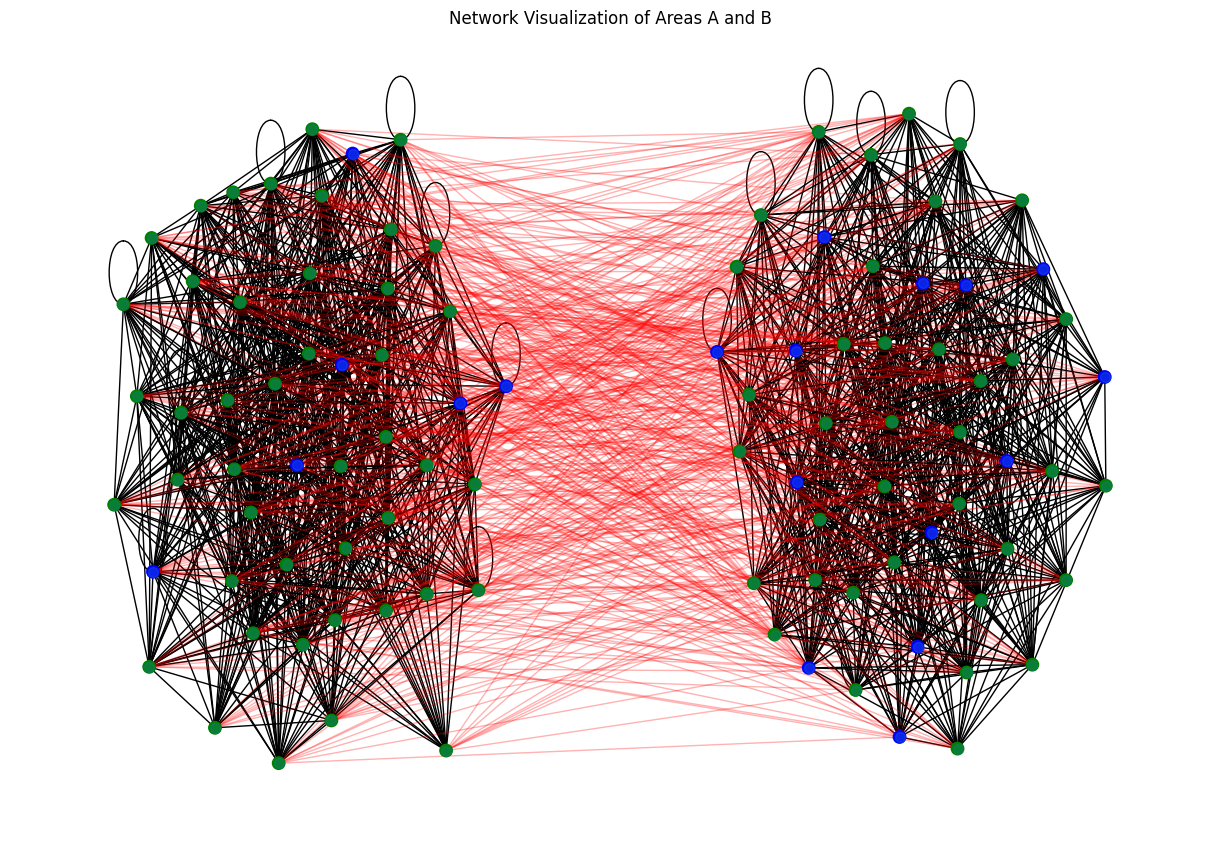

In [33]:
params = initialize_parameters()
neuron_types, connectivity_within, connectivity_between = initialize_network(params)

N = len(neuron_types)
area_size = N // 2
    
G_A = nx.Graph()
G_B = nx.Graph()

    # Add nodes to each area graph
G_A.add_nodes_from(range(area_size))
G_B.add_nodes_from(range(area_size, N))
    
    # Add edges within area A
for i in range(area_size):
    for j in range(area_size):
        if connectivity_within["pee"][i, j] or connectivity_within["pei"][i, j] or connectivity_within["pie"][i, j] or connectivity_within["pii"][i, j]:
            G_A.add_edge(i, j)
    
    # Add edges within area B
for i in range(area_size, N):
    for j in range(area_size, N):
        if connectivity_within["pee"][i, j] or connectivity_within["pei"][i, j] or connectivity_within["pie"][i, j] or connectivity_within["pii"][i, j]:
            G_B.add_edge(i, j)
    
    # Add edges between areas A and B
G = nx.Graph()
G.add_nodes_from(range(N))
for i in range(area_size):
    for j in range(area_size, N):
        if connectivity_between["pAee"][i, j] or connectivity_between["pAie"][i, j] or connectivity_between["pAei"][i, j] or connectivity_between["pAii"][i, j]:
            G.add_edge(i, j)
    
    # Position nodes in separate clusters
pos_A = nx.spring_layout(G_A)
pos_B = nx.spring_layout(G_B)
    
    # Offset positions to separate the clusters
offset = 3.0  # Adjust this value to increase or decrease the distance between clusters
for key in pos_B:
    pos_B[key] = (pos_B[key][0] + offset, pos_B[key][1])
    
pos = {**pos_A, **pos_B}
    
    # Color mapping for excitatory and inhibitory neurons
color_map = []
for i in range(area_size):
    if neuron_types[i] == 1:
        color_map.append('green')  # Excitatory neurons in area A
    else:
        color_map.append('blue')  # Inhibitory neurons in area A
    
for i in range(area_size, N):
    if neuron_types[i] == 1:
        color_map.append('green')  # Excitatory neurons in area B
    else:
        color_map.append('blue')  # Inhibitory neurons in area B
    
plt.figure(figsize=(12, 8))
nx.draw(G_A, pos_A, node_color=color_map[:area_size], node_size=80, with_labels=False)
    
nx.draw(G_B, pos_B, node_color=color_map[area_size:], node_size=80, with_labels=False)
nx.draw(G, pos, node_size=50, with_labels=False, alpha=0.3, edge_color='red')
    
plt.title("Network Visualization of Areas A and B")
plt.show()

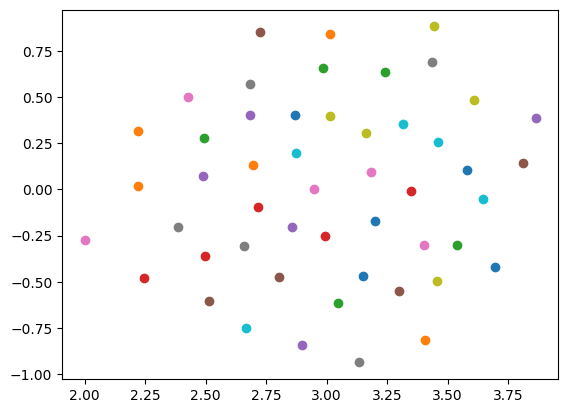

In [18]:
for k in pos_B:
    plt.scatter(pos_B[k][0],pos_B[k][1])

In [ ]:
nx.draw(G_A, pos_A, node_color=color_map[:area_size], node_size=80, with_labels=False)
    
nx.draw(G_B, pos_B, node_color=color_map[area_size:], node_size=80, with_labels=False)
nx.draw(G, pos, node_size=50, with_labels=False, alpha=0.3, edge_color='red')

In [38]:
pos_A = nx.spring_layout(G_A,dim=3)
pos_B = nx.spring_layout(G_B,dim=3)

offset = 3.0  # Adjust this value to increase or decrease the distance between clusters
for key in pos_B:
    pos_B[key] = (pos_B[key][0] + offset, pos_B[key][1])
    
pos_AB = {**pos_A, **pos_B}

{0: array([ 0.04097263,  0.686798  , -0.66194712]),
 1: array([-0.67518382, -0.31409725, -0.53424451]),
 2: array([ 0.57742345, -0.14731685, -0.17419012]),
 3: array([ 0.37278388, -0.7728698 ,  0.34552698]),
 4: array([-0.35398745, -0.02925996, -0.74477522]),
 5: array([-0.23482993,  0.35346744, -0.57034063]),
 6: array([0.11985733, 0.00960922, 0.75999066]),
 7: array([ 0.6077555 , -0.05384645,  0.57236935]),
 8: array([-0.37082864, -0.52462549, -0.39770944]),
 9: array([-0.87808288,  0.24965535,  0.082523  ]),
 10: array([-0.42673168,  0.5156998 ,  0.71395801]),
 11: array([0.17242317, 0.27452776, 0.50767999]),
 12: array([-0.13607002,  0.24653119,  0.50349979]),
 13: array([0.3896777 , 0.28637319, 0.66962051]),
 14: array([-0.1570226 , -0.48324146, -0.15509051]),
 15: array([ 0.59131564,  0.19320593, -0.48095023]),
 16: array([0.25302748, 0.83387593, 0.1767542 ]),
 17: array([0.45493864, 0.04328201, 0.11623852]),
 18: array([ 0.43877027, -0.49774702, -0.39316109]),
 19: array([-0.205

In [34]:
nodes_a = np.array([pos_A[v] for v in G_A])
edges_a = np.array([(pos_A[u], pos_A[v]) for u, v in G_A.edges()])

nodes_b = np.array([pos_B[v] for v in G_B])
edges_b = np.array([(pos_B[u], pos_B[v]) for u, v in G_B.edges()])

nodes_ab = np.array([pos_AB[v] for v in G])
edges_ab = np.array([(pos_AB, pos_AB[v]) for u, v in G.edges()])



ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (100,) + inhomogeneous part.

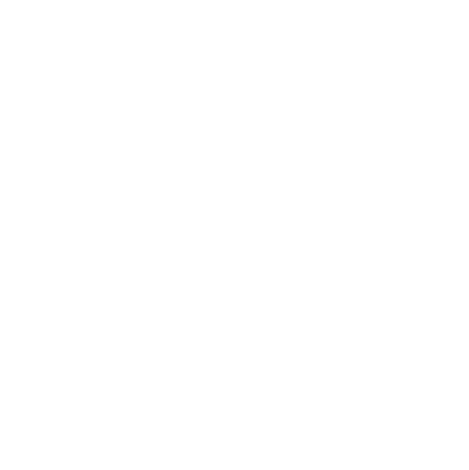

<Figure size 640x480 with 0 Axes>

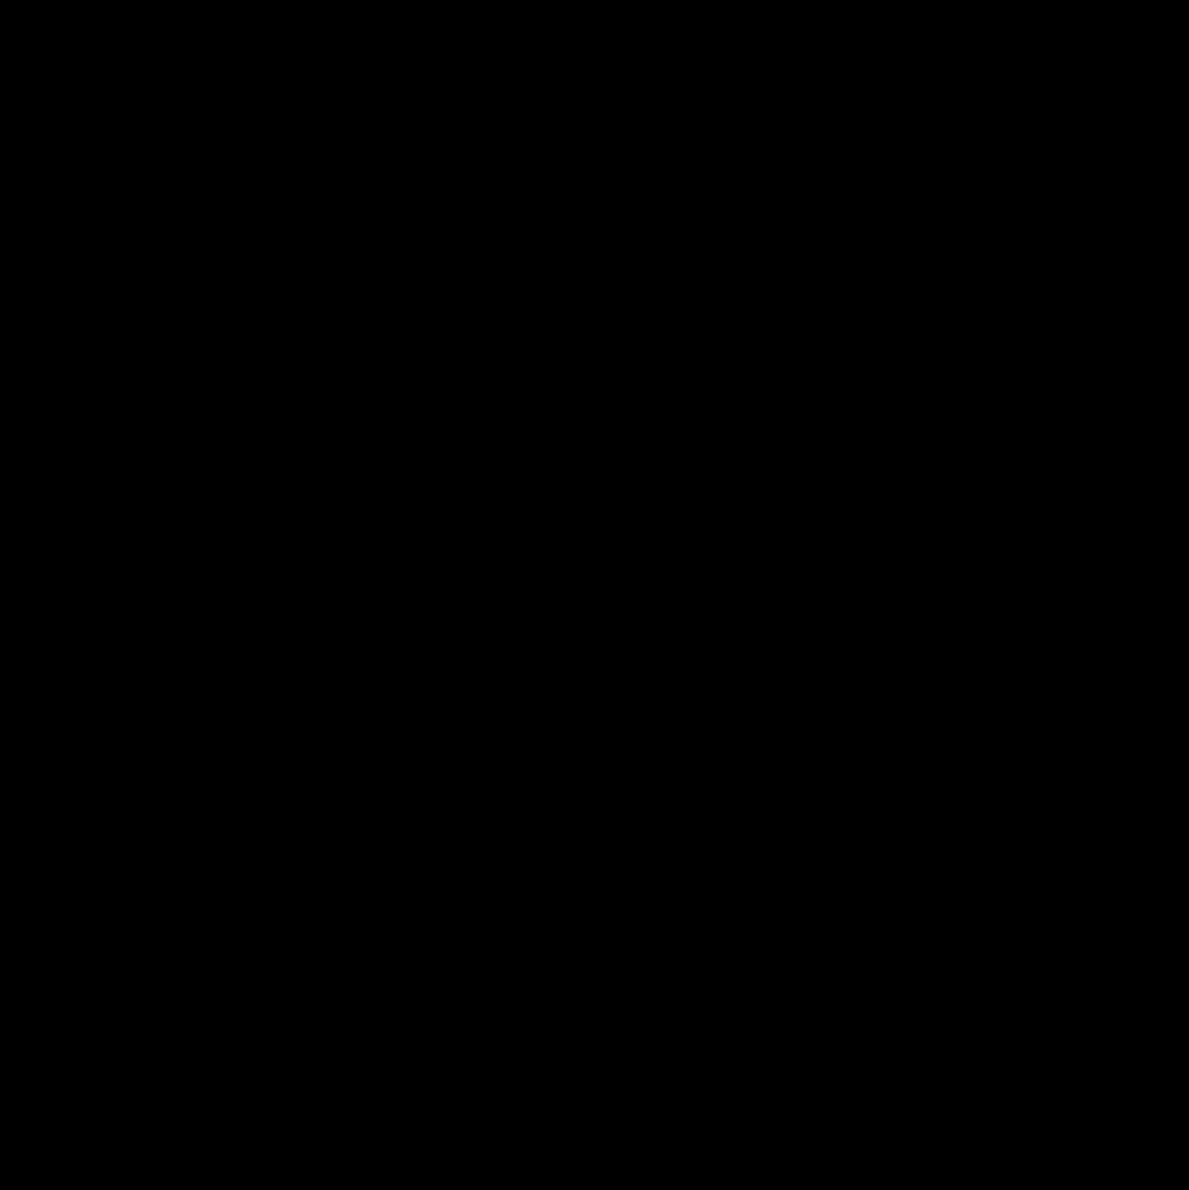

<Figure size 640x480 with 0 Axes>

In [9]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib import animation
import random

# Initialize parameters
def initialize_parameters():
    params = {
        "N": 100,
        "Pexc": 0.8,
        "Pinh": 0.2,
        "connection_prob": {
            "pee": 0.05,
            "pii": 0.2,
            "pei": 0.05,
            "pie": 0.05,
            "pAee": 0.01,
            "pAei": 0.05,
            "pAii": 0.1,
            "pAie": 0.05
        }
    }
    return params

# Initialize the network
def initialize_network(params):
    N = 100
    neuron_types = np.random.choice([0, 1], size=N, p=[params["Pinh"], params["Pexc"]])
    
    connectivity_within = {
        "pee": np.random.rand(N, N) < params["connection_prob"]["pee"],
        "pii": np.random.rand(N, N) < params["connection_prob"]["pii"],
        "pei": np.random.rand(N, N) < params["connection_prob"]["pei"],
        "pie": np.random.rand(N, N) < params["connection_prob"]["pie"]
    }

    connectivity_between = {
        "pAee": np.random.rand(N, N) < params["connection_prob"]["pAee"],
        "pAei": np.random.rand(N, N) < params["connection_prob"]["pAei"],
        "pAii": np.random.rand(N, N) < params["connection_prob"]["pAii"],
        "pAie": np.random.rand(N, N) < params["connection_prob"]["pAie"]
    }
    
    return neuron_types, connectivity_within, connectivity_between

# Visualize and animate the network in 3D using matplotlib
def visualize_network():
    params = initialize_parameters()
    neuron_types, connectivity_within, connectivity_between = initialize_network(params)
    
    N = params["N"]
    area_size = N // 2
    
    G_A = nx.Graph()
    G_B = nx.Graph()
    
    # Add nodes to each area graph
    G_A.add_nodes_from(range(area_size))
    G_B.add_nodes_from(range(area_size, N))
    
    # Add edges within area A
    for i in range(area_size):
        for j in range(area_size):
            if connectivity_within["pee"][i, j] or connectivity_within["pei"][i, j] or connectivity_within["pie"][i, j] or connectivity_within["pii"][i, j]:
                G_A.add_edge(i, j)
    
    # Add edges within area B
    for i in range(area_size, N):
        for j in range(area_size, N):
            if connectivity_within["pee"][i, j] or connectivity_within["pei"][i, j] or connectivity_within["pie"][i, j] or connectivity_within["pii"][i, j]:
                G_B.add_edge(i, j)
    
    # Add edges between areas A and B
    G = nx.Graph()
    G.add_nodes_from(range(N))
    for i in range(area_size):
        for j in range(area_size, N):
            if connectivity_between["pAee"][i, j] or connectivity_between["pAie"][i, j] or connectivity_between["pAei"][i, j] or connectivity_between["pAii"][i, j]:
                G.add_edge(i, j)
    
    # Generate 3D positions for the nodes
    scale_factor = 180  # Increase this value to make the network larger
    pos = np.random.rand(N, 3)*scale_factor
    pos[area_size:] += scale_factor  # Offset cluster B positions for visualization

    # Collect edges for visualization
    edges_within_A = [pos[[start, end]] for start, end in G_A.edges()]
    edges_within_B = [pos[[start, end]] for start, end in G_B.edges()]
    edges_between = [pos[[start, end]] for start, end in G.edges() if start < area_size and end >= area_size]
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection="3d")
    ax.grid(False)
    ax.set_axis_off()
    plt.tight_layout()
    node = [0]
    
    def _frame_update(index):
        ax.clear()
        ax.scatter(*pos[:area_size].T, alpha=0.8, s=80, color="blue")  # Cluster A
        ax.scatter(*pos[area_size:].T, alpha=0.8, s=80, color="green")  # Cluster B
        
        for vizedge in edges_within_A:
            ax.plot(*vizedge.T, lw=0.5, color="red")
        for vizedge in edges_within_B:
            ax.plot(*vizedge.T, lw=0.5, color="red")
        for vizedge in edges_between:
            ax.plot(*vizedge.T, lw=0.5, color="gray")
        
        neighbors = list(G.neighbors(node[0]))
        if index % 5 == 0:
            node[0] = random.choice(neighbors)
        node0 = pos[node[0]]
        #ax.scatter(*node0, alpha=1, marker="s", color="red", s=100)
        ax.view_init(index * 0.2, index * 0.5)
        ax.grid(False)
        ax.set_axis_off()
        plt.tight_layout()
        return
    
    ani = animation.FuncAnimation(
        fig,
        _frame_update,
        interval=50,
        cache_frame_data=False,
        frames=500,
    )
    plt.show()
    ani.save('network.mp4')

visualize_network()
